# Classification Groups
A classification group is a set of genes that, when used as features, results in a high accuracy classifier for a state. The genes in a classification group may well be surrogates for transcription modules or programs. This can be exposed by looking for transcription factors common across groups for a single state.

# Analysis of Features by Classification Accuracy

In [1]:
import init
import common.constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
import classifier.main_multi_classifier_feature_optimizer as main
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots

import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Create Base Data

In [2]:
# These are the "long" data that have individual replications, not averages
PROVIDER = DataProvider()
PROVIDER.do()
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False)  # Trinary data
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
STATES = SER_Y.unique()
path = os.path.join(cn.DATA_DIR, "fit_result.xlsx")
DF_FIT = pd.read_excel(path)
DF_FIT.head()

,state,index,GENE_ID,score,count
0,0,0,Rv2626c,1.0,1
1,0,1,Rv1813c,1.0,1
2,0,2,Rv0022c,1.0,117
3,0,2,Rv2007c,1.0,117
4,0,2,Rv3854c,1.0,117


In [3]:
PROVIDER.df_trn_signed.head()

,tf,GENE_ID,sign
0,Rv0022c,Rv0029,1
1,Rv0022c,Rv0030,1
2,Rv0022c,Rv0031,1
3,Rv0022c,Rv0069c,1
4,Rv0022c,Rv0070c,1


In [4]:
# Transcription factors
TFS = PROVIDER.df_trn_unsigned[cn.TF].unique()
TFS = list(set(TFS).intersection(TRINARY.df_X.columns))
len(TFS)

96

## Monitor Progress on Constructing Classification Groups

In [5]:
FIT_RESULT_DCT = main.getFitResultFromPersister()
def run():
    for cl in FIT_RESULT_DCT.keys():
        length_stg = str([len(fr.sels) for fr in FIT_RESULT_DCT[cl]])
        score_stg = str([fr.sels_score for fr in FIT_RESULT_DCT[cl]])
        n_eval_stg = str([fr.n_eval for fr in FIT_RESULT_DCT[cl]])
        print("%d: %s\n   %s\n   %s" % (cl, length_stg, score_stg, n_eval_stg))
if False:
    run()

In [6]:
# Check status of run
if False:
    df_g = pd.DataFrame(DF_CSV.groupby([cn.STATE, cn.INDEX]).count())
    dff = df_g.reset_index()
    for state in DF_CSV[cn.STATE].unique():
        dff_state = dff[dff[cn.STATE] == state]
        print("%d: %d" % (state, dff_state[cn.INDEX].max()))

## Data Construction for Classification Groups

In [7]:
# Group by state and index
dfg = DF_FIT.groupby([cn.STATE, cn.INDEX])
df_g = pd.DataFrame(dfg.count())
df_g[cn.COUNT] = dfg.count()
for col in df_g.columns:
    if col != cn.COUNT:
        del df_g[col]              
df_g = df_g.reset_index()
df_g[cn.SCORE] = dfg.mean().reset_index()[cn.SCORE]
state = 0
df = df_g[df_g[cn.STATE] == state]
#plt.scatter(df[cn.INDEX], df[cn.SCORE])
df_g.head()

,state,index,count,score
0,0,0,1,1.000000
1,0,1,1,1.000000
2,0,2,3,1.000000
3,0,3,2,0.993333
4,0,4,2,1.000000


In [8]:
PROVIDER.df_trn_unsigned

,tf,GENE_ID,sign
0,Rv0022c,Rv0029,1
1,Rv0022c,Rv0030,1
2,Rv0022c,Rv0031,1
3,Rv0022c,Rv0069c,1
4,Rv0022c,Rv0070c,1
...,...,...,...
12183,Rv3862c,Rv3881c,1
12184,Rv3911,Rv2514c,1
12185,Rv3911,Rv2515c,1
12186,Rv3911,Rv3906c,1


In [9]:
df_merge = DF_FIT.merge(PROVIDER.df_trn_unsigned)

In [10]:
df_merge.head()

,state,index,GENE_ID,score,count,tf,sign
0,0,0,Rv2626c,1.0,1,Rv1985c,1
1,0,0,Rv2626c,1.0,1,Rv3133c,1
2,0,1,Rv1813c,1.0,1,Rv1985c,1
3,0,2,Rv0022c,1.0,117,Rv1033c,1
4,0,2,Rv0022c,1.0,117,Rv3597c,1


In [11]:
# Construct a dataframe that merges classification group with transcription factors
df_merge = DF_FIT.merge(PROVIDER.df_trn_unsigned)
del df_merge[cn.SIGN]
del df_merge[cn.COUNT]
df_merge = df_merge.drop_duplicates()
df_merge = df_merge.sort_values([cn.STATE, cn.INDEX, cn.TF])
df_merge.head()

,state,index,GENE_ID,score,tf
0,0,0,Rv2626c,1.0,Rv1985c
1,0,0,Rv2626c,1.0,Rv3133c
2,0,1,Rv1813c,1.0,Rv1985c
8,0,2,Rv3854c,1.0,Rv0324
3,0,2,Rv0022c,1.0,Rv1033c


## Analysis Transcription Factor by Class
This analysis examines commonalities in the transcription factors of classification groups.

In [12]:
df_tf = df_merge.copy()
del df_tf[cn.GENE_ID]
df_tf[cn.GROUP] = df_tf[cn.INDEX]
del df_tf[cn.INDEX]
df_tf = df_tf.drop_duplicates()
df_tf.head()

,state,score,tf,group
0,0,1.0,Rv1985c,0
1,0,1.0,Rv3133c,0
2,0,1.0,Rv1985c,1
8,0,1.0,Rv0324,2
3,0,1.0,Rv1033c,2


In [13]:
STATE = 0
df_plot = df_tf[df_tf[cn.STATE] == STATE]
df_plot = df_plot.copy()
df_plot.index = [str(i) for i in df_plot.index]
del df_plot[cn.STATE]
df_plot = df_plot.pivot(index=cn.GROUP, columns=cn.TF, values=cn.SCORE)
df_plot.columns = [str(c) for c in df_plot.columns]
df_plot.head()

,Rv0022c,Rv0023,Rv0042c,Rv0047c,Rv0081,Rv0135c,Rv0302,Rv0324,Rv0353,Rv0465c,...,Rv3249c,Rv3416,Rv3488,Rv3574,Rv3597c,Rv3681c,Rv3736,Rv3830c,Rv3849,Rv3855
group,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
3,NaN,NaN,NaN,0.993333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_tf[df_tf[cn.STATE] == state]

,state,score,tf,group
0,0,1.0,Rv1985c,0
1,0,1.0,Rv3133c,0
2,0,1.0,Rv1985c,1
8,0,1.0,Rv0324,2
3,0,1.0,Rv1033c,2
...,...,...,...,...
353,0,0.5,Rv1033c,29
354,0,0.5,Rv1353c,29
355,0,0.5,Rv1460,29
356,0,0.5,Rv1816,29


In [15]:
df_plot.head()

,Rv0022c,Rv0023,Rv0042c,Rv0047c,Rv0081,Rv0135c,Rv0302,Rv0324,Rv0353,Rv0465c,...,Rv3249c,Rv3416,Rv3488,Rv3574,Rv3597c,Rv3681c,Rv3736,Rv3830c,Rv3849,Rv3855
group,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
3,NaN,NaN,NaN,0.993333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


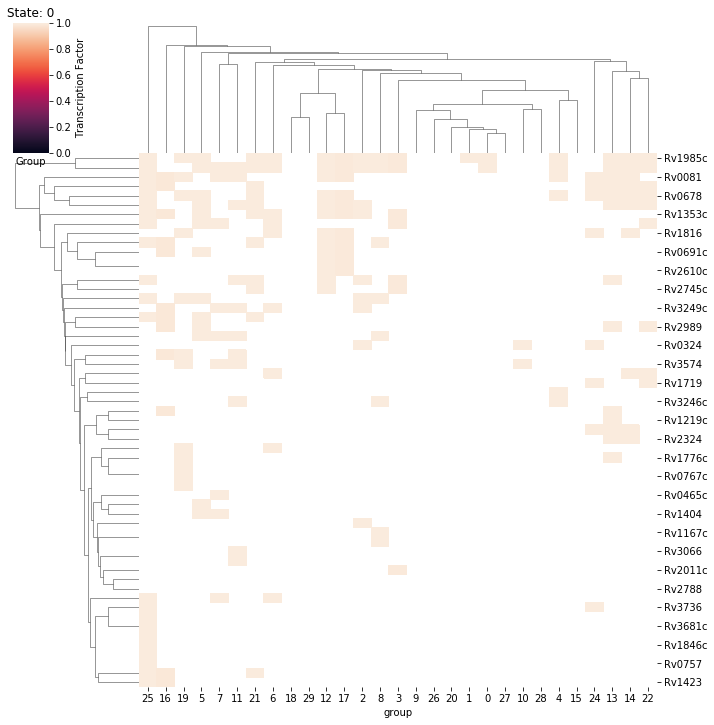

In [16]:
import seaborn
def plotTFByGroup(state, min_score=0.9):
    # Construct the data
    df_plot = df_tf[df_tf[cn.STATE] == state]
    df_plot = df_plot.copy()
    del df_plot[cn.STATE]
    df_plot = df_plot.pivot(index=cn.GROUP, columns=cn.TF, values=cn.SCORE)
    df_plot.columns = [str(c) for c in df_plot.columns]
    # Do the plot
    if False:
        plt.figure(figsize=(18, 10))
        ax = plt.gca()
        ax.set_xticks(np.arange(len(df_plot.index))+0.5)
        ax.set_xticklabels(df_plot.index, rotation=0)
        ax.set_yticks(np.arange(len(df_plot.columns))+0.5)
        ax.set_yticklabels(df_plot.columns, rotation=0)
        ax.set_xlabel(cn.GROUP)
        ax.set_ylabel("transcription factor")
        #heatmap = plt.pcolor(df_plot.T)
        #_ = plt.colorbar(heatmap)
    df_plot = df_plot.applymap(lambda v: 0 if np.isnan(v) else v)
    cg = seaborn.clustermap(df_plot.T, row_cluster=True, col_cluster=True, mask=df_plot.T.applymap(lambda v: v <0.9))
    plt.title("State: %d" % state)
    plt.xlabel("Group")
    plt.ylabel("Transcription Factor")
    
plotTFByGroup(0)

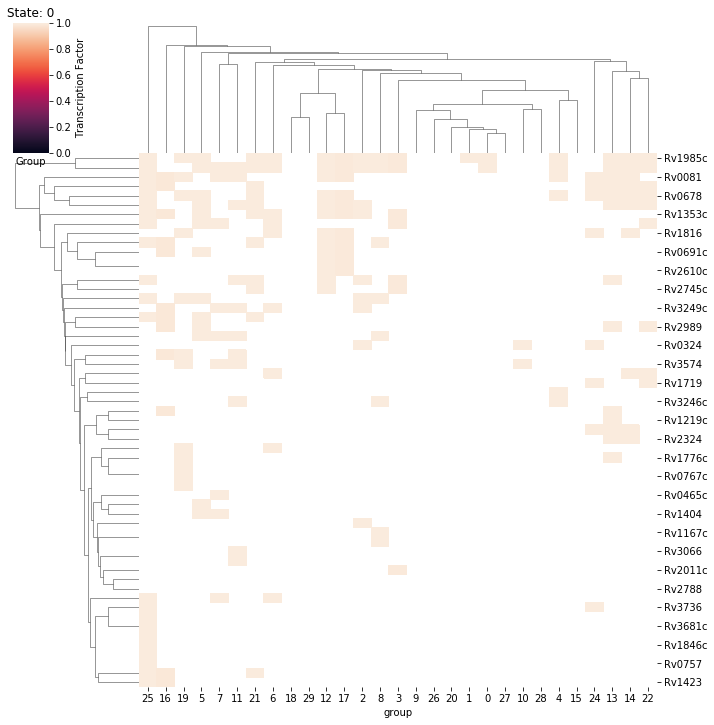

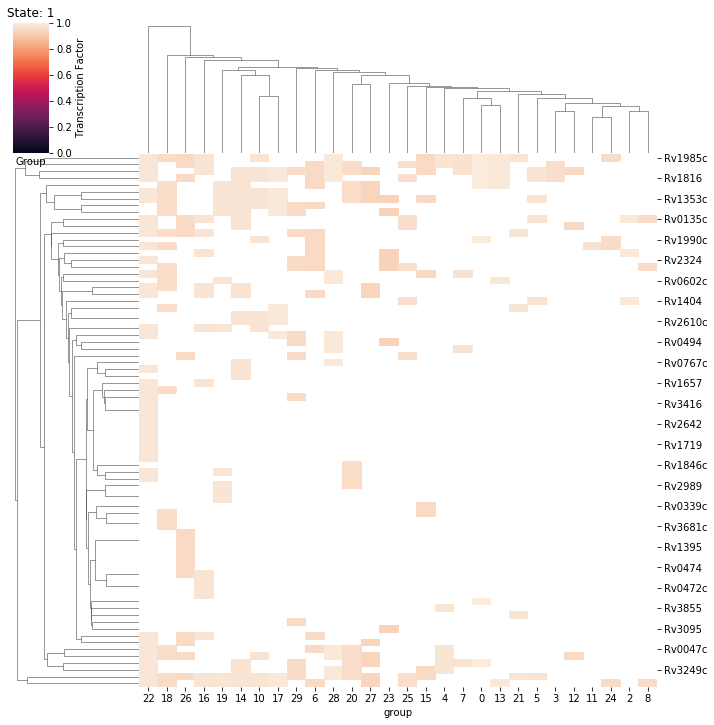

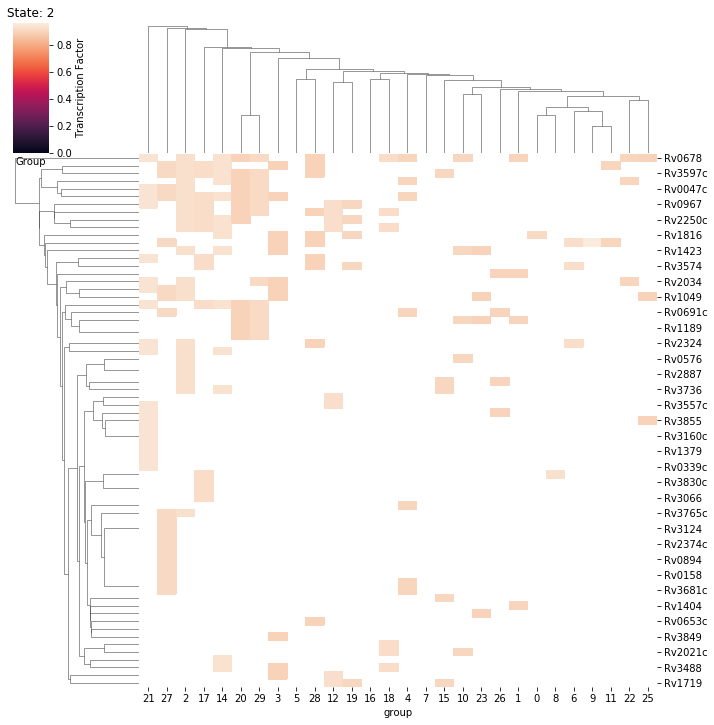

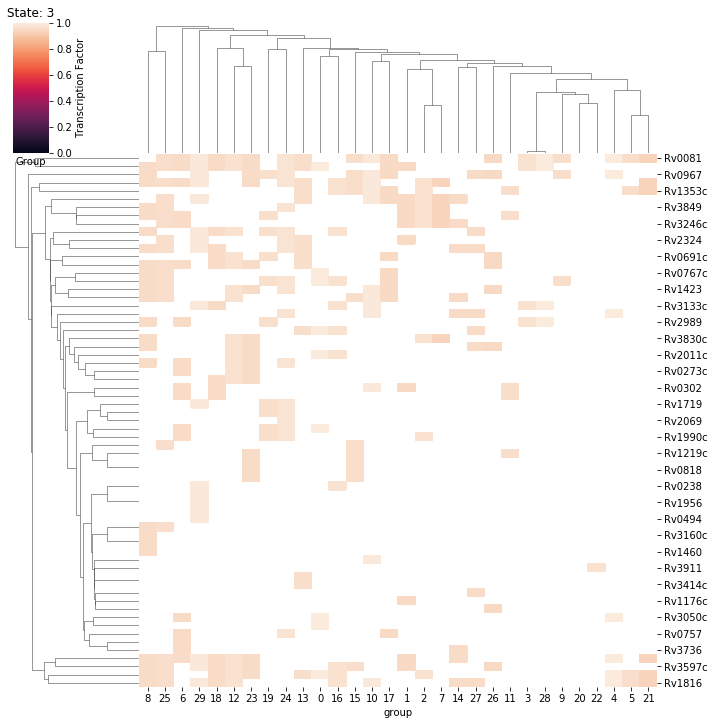

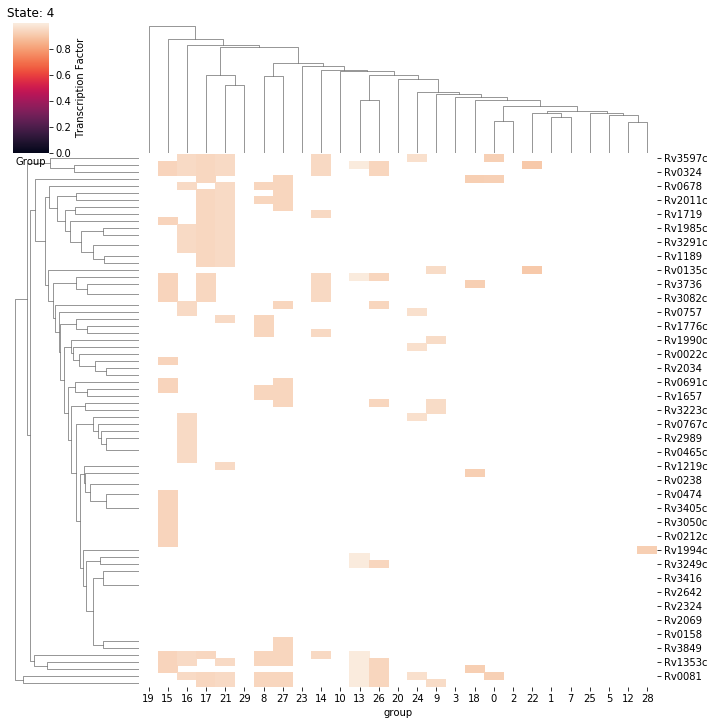

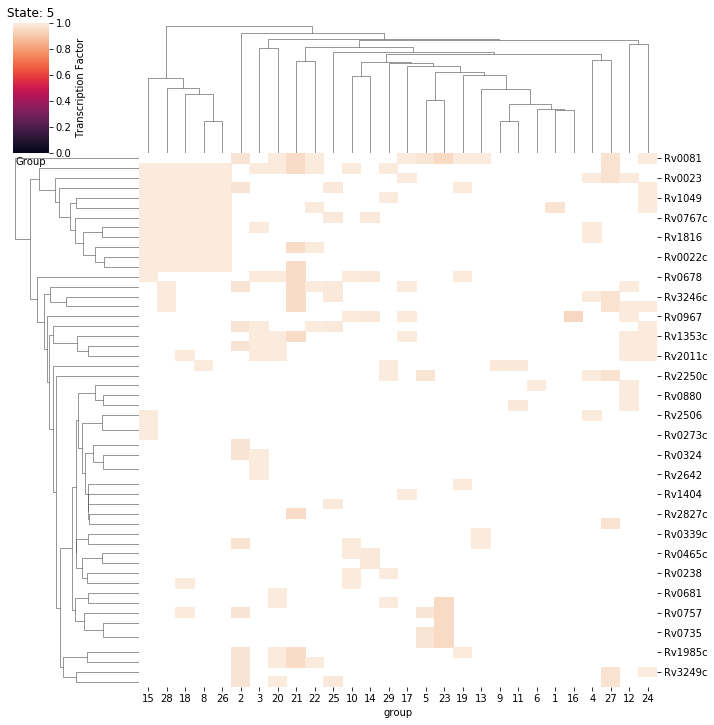

In [17]:
for state in range(6):
    plotTFByGroup(state)

## Correlations of Transcription Factors
To identify gene programs, look for correlations among transcription factors by state.

In [18]:
len(set(TFS).intersection(TRINARY.df_X.columns))

96

In [19]:
def plotCorr(state):
    indices = SER_Y[SER_Y == state].index
    df_X = DF_X.loc[indices, :]
    util_plots.plotCorr(df_X[TFS], is_yticklabels=True, is_xticklabels=True)

/home/ubuntu/xstate/common_python/common_python/plots/util_plots.py:127: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cg.fig.show()


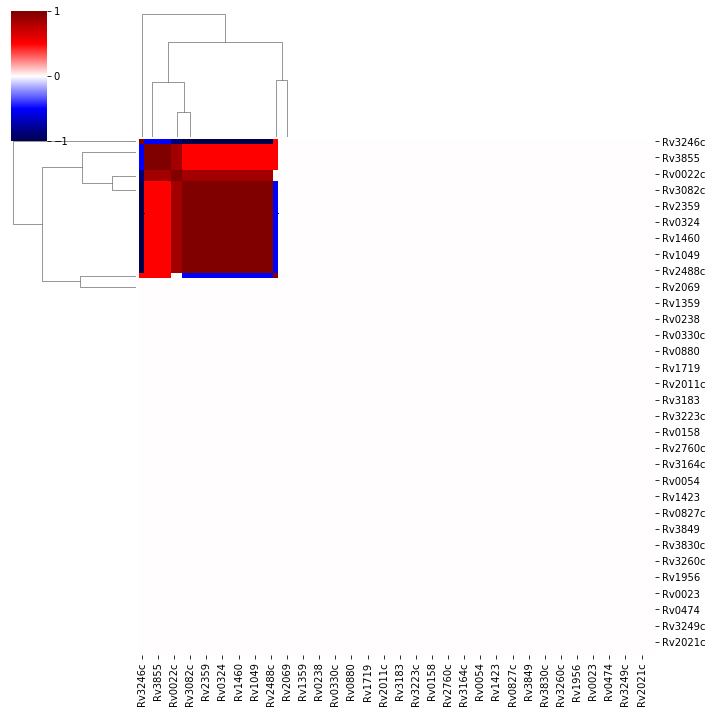

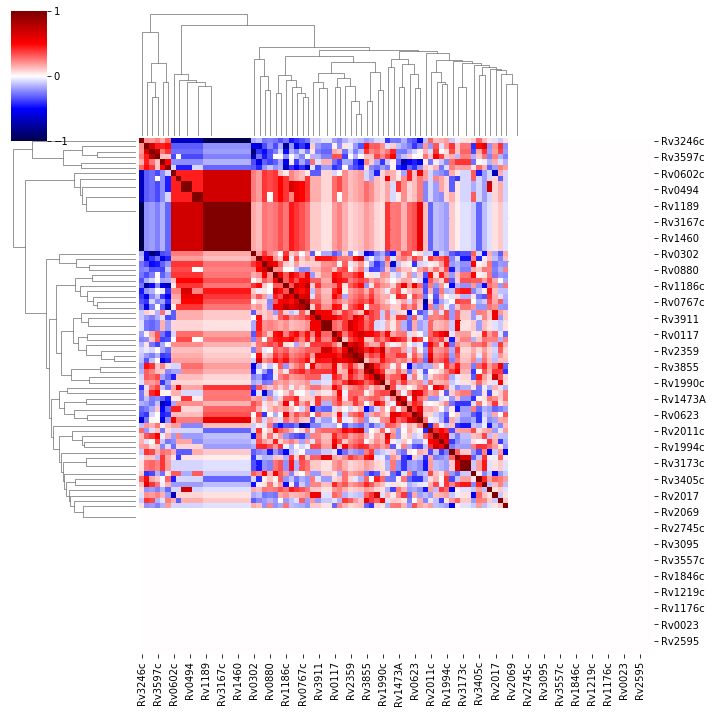

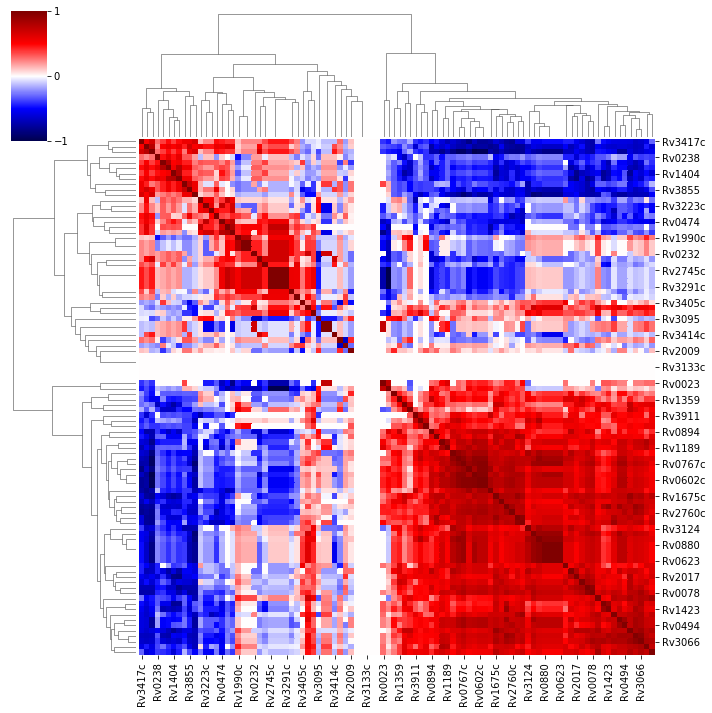

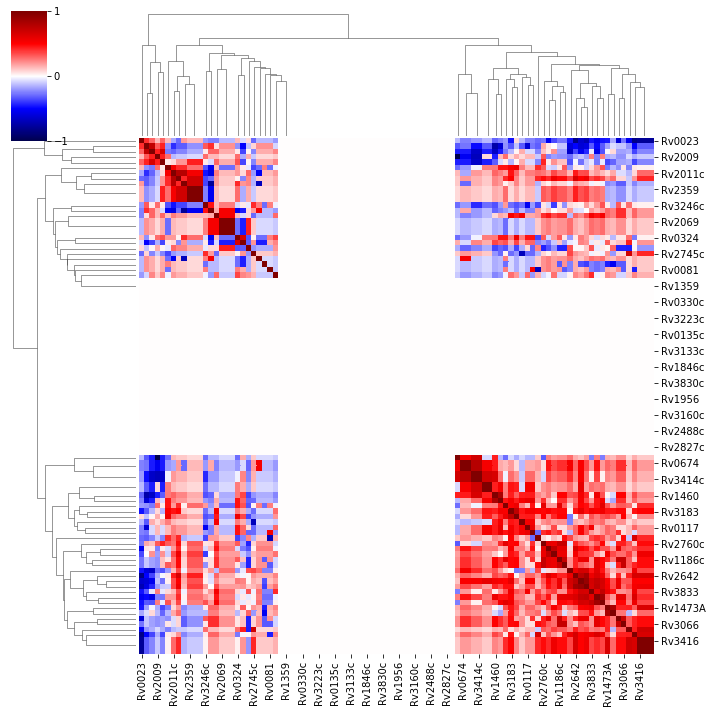

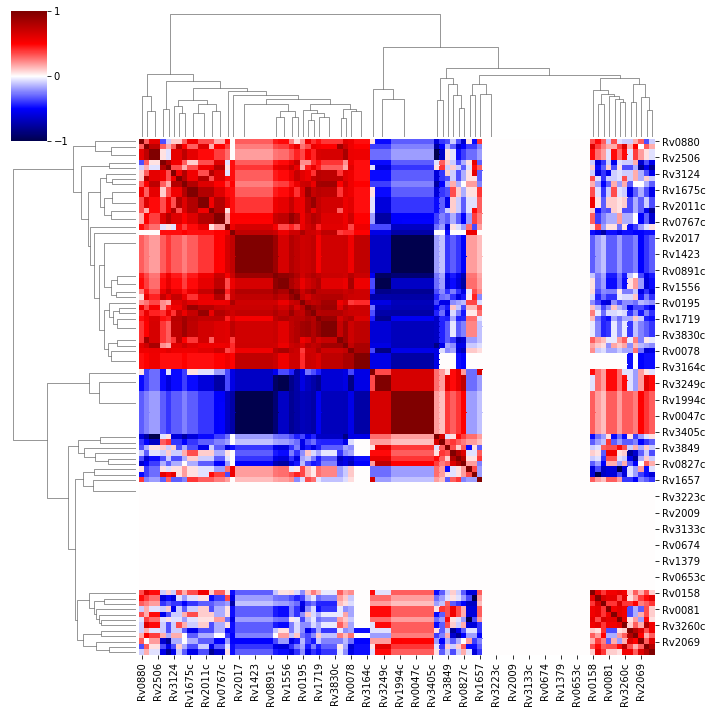

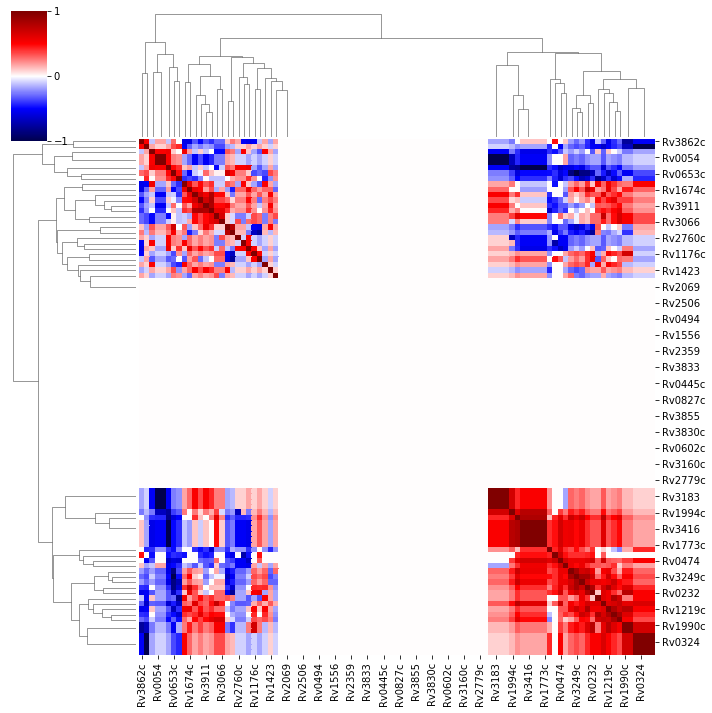

In [20]:
for state in STATES:
    plotCorr(state)